# Simple speech recognition

Audio 데이터를 다뤄서 학습하는 방법을 배워보도록 합시다.
머신러닝 작업과정은 아래와 같습니다.

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

* 모델 완성 후 평가 지표에 따라서 모델을 평가해 봅시다.
* tensorflow 2.1 버전에 최적화되어있습니다.

## Project 설명
### Task
* 1초 길이의 오디오 음성데이터를 이용해 단어를 분류하는 것이 목표입니다.
* 주어진 데이터를 이용해 딥러닝 트레이닝 과정을 구현해 보는것이 목표입니다.
* This code is borrowed from [Kaggle/TensorFlow Speech Recognition Challenge](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge).
* This is version 0.01 of the data set containing 64,727 audio files, released on August 3rd 2017.
- **1초 길이의 오디오 음성 데이터 -> sample rate = 8000 ( Per second ) ( Img의 픽셀과 비슷 )**
- **1Batch = 8000**
- **shape = (32,8000,1)**


### Baseline
* 기본적으로 사용하는 Convulution layers를 구성해 사용해보자.
    * ex) Conv - Conv - pooling - FC layers
* 오버피팅을 방지하기 위한 다양한 방법들을 사용해보자.
* Training
    * tf.data.dataset과 model.fit()을 사용
    - **data.dataset -> 특정 데이터 형식 상관 X**
* Evaluation
    * 모델의 정확도와 크기를 이용해 점수를 제공하는 메트릭으로 평가해보자.

### Setting tensorflow version

In [1]:
#!pip install tensorflow-gpu==2.1

### Import packages

* 우리가 사용할 packages 를 import 하는 부분 입니다.
* 필요에 따른 packages를 선언합니다.

In [2]:
import os
os.path

<module 'posixpath' from '/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/posixpath.py'>

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
#sklearn - 머신러닝을 위한 패키지
#dataset을 다뤄줌
import librosa
#audio data를 다룰때 필수적
import librosa.display
import matplotlib.pyplot as plt

import os
from os.path import isdir, join

import random
import copy

tf.__version__


'2.1.0'

## Import modules

### Import colab modules for Google Colab (if necessary)

### Load dataset

In [4]:
speech_data = np.load("content/datasets/speech_wav_8000.npz")

In [5]:
speech_data["wav_vals"].shape

(50620, 8000)

In [6]:
speech_data["wav_vals"][0].shape

(8000,)

In [7]:
import IPython.display as ipd

rate = 8000
data = speech_data["wav_vals"][25]

ipd.Audio(data, rate=rate) # load a NumPy array

In [8]:
speech_data["label_vals"]

array([['down'],
       ['down'],
       ['down'],
       ...,
       ['silence'],
       ['silence'],
       ['silence']], dtype='<U7')

### Model dataset setting
* 변환된 데이터를 이용해서 학습에 활용할 데이터셋을 설정한다.

In [9]:
sr = 8000
train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"], 
                                                                speech_data["label_vals"], 
                                                                test_size=0.1,#data-test 비율
                                                                shuffle=True)

#convolution에 맞는 데이터 (-1:any,sr:유지,1) - 모양 변경에 필요 (50000,8000,1)
train_wav = train_wav.reshape(-1,sr,1)
test_wav = test_wav.reshape(-1,sr,1)

print(train_wav.shape)
print(test_wav.shape)
print(train_label.shape)
print(test_label.shape)

(45558, 8000, 1)
(5062, 8000, 1)
(45558, 1)
(5062, 1)


In [10]:
#Target
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
label_value = target_list
label_value.append('unknown')
label_value.append('silence')

#key - list, value - number
new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

In [11]:
label_value

{'yes': 0,
 'no': 1,
 'up': 2,
 'down': 3,
 'left': 4,
 'right': 5,
 'on': 6,
 'off': 7,
 'stop': 8,
 'go': 9,
 'unknown': 10,
 'silence': 11}

In [12]:
temp = []
for v in train_label:
    temp.append(label_value[v[0]])
train_label = np.array(temp)

temp = []
for v in test_label:
    temp.append(label_value[v[0]])
test_label = np.array(temp)

In [13]:
print('Train_Wav Demension : ' + str(np.shape(train_wav)))
print('Train_Label Demension : ' + str(np.shape(train_label)))
print('Test_Wav Demension : ' + str(np.shape(test_wav)))
print('Test_Label Demension : ' + str(np.shape(test_label)))
print('Number Of Labels : ' + str(len(label_value)))

Train_Wav Demension : (45558, 8000, 1)
Train_Label Demension : (45558,)
Test_Wav Demension : (5062, 8000, 1)
Test_Label Demension : (5062,)
Number Of Labels : 12


### Hyper-parameters setting

In [14]:
batch_size = 100
max_epochs = 20

# the save point
checkpoint_dir ='./train_ckpt/wave/exp5'
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)
os.path.isdir(checkpoint_dir)

True

In [15]:
# train_wav, train_label
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label

In [16]:
# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label)) # wave랑 label return
train_dataset = train_dataset.map(one_hot_label) # .map(one_hot_label())

#repeat을 넣어야 keras.model.fit과 사용 가능(gradient Tape과 사용할때는 필요 없음)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>


In [17]:
# for test
test_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>


### Model 구현
* Wave 파일 데이터를 이용해 학습을 할 수 있는 모델을 구현합니다.

In [18]:
input_tensor = layers.Input(shape=(sr, 1))

x = layers.Conv1D(64,9,padding="same",kernel_initializer='he_normal')(input_tensor)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
# x = layers.MaxPooling1D()(x)
x = layers.Conv1D(64,9,padding="same",kernel_initializer='he_normal')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling1D()(x)
x = layers.Conv1D(128,9,padding="same",kernel_initializer='he_normal')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling1D()(x)
# x = layers.Conv1D(512,9,padding="same",kernel_initializer='he_normal')(x)
# x = layers.BatchNormalization()(x)
# x = layers.Activation('relu')(x)
# x = layers.MaxPooling1D()(x)
x = layers.Flatten()(x)
x = layers.Dense(128,activation='relu')(x)
x = layers.Dense(12,activation='softmax')(x)

model = tf.keras.Model(inputs=input_tensor, outputs=x)

In [19]:
optimizer=tf.keras.optimizers.Adam(learning_rate=0.002)
model.compile(loss=tf.keras.losses.categorical_crossentropy,
             optimizer=optimizer,
             metrics=['accuracy'])

### 구성된 모델 확인

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 8000, 64)          640       
_________________________________________________________________
batch_normalization (BatchNo (None, 8000, 64)          256       
_________________________________________________________________
activation (Activation)      (None, 8000, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8000, 64)          36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 8000, 64)          256       
_________________________________________________________________
activation_1 (Activation)    (None, 8000, 64)          0     

### 모델 Callback

In [21]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [22]:
def scheduler(epoch):
    if epoch < 10:
        return 0.0001
    else:
        return 0.0001 * tf.math.exp(0.1 * (10 - epoch))

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

### 모델 학습

In [23]:
# using `tf.data.Dataset`
history = model.fit(train_dataset,
                    epochs=max_epochs,
                    steps_per_epoch=train_wav.shape[0]/batch_size,
                    validation_data=test_dataset,
                    validation_steps=test_wav.shape[0]/batch_size,
                    callbacks=[lr_callback,cp_callback]
                    )

Train for 455.58 steps, validate for 50.62 steps
Epoch 1/20
455/455 [============================>.] - ETA: 0s - loss: 2.3906 - accuracy: 0.1632
Epoch 00001: val_loss improved from inf to 2.22837, saving model to ./train_ckpt/wave/exp5
456/455 [==============================] - 121s 266ms/step - loss: 2.3900 - accuracy: 0.1633 - val_loss: 2.2284 - val_accuracy: 0.2361
Epoch 2/20
455/455 [============================>.] - ETA: 0s - loss: 2.0614 - accuracy: 0.2679
Epoch 00002: val_loss improved from 2.22837 to 1.93152, saving model to ./train_ckpt/wave/exp5
456/455 [==============================] - 119s 261ms/step - loss: 2.0611 - accuracy: 0.2679 - val_loss: 1.9315 - val_accuracy: 0.3000
Epoch 3/20
455/455 [============================>.] - ETA: 0s - loss: 1.8362 - accuracy: 0.3426
Epoch 00003: val_loss improved from 1.93152 to 1.78895, saving model to ./train_ckpt/wave/exp5
456/455 [==============================] - 120s 263ms/step - loss: 1.8360 - accuracy: 0.3427 - val_loss: 1.7890 

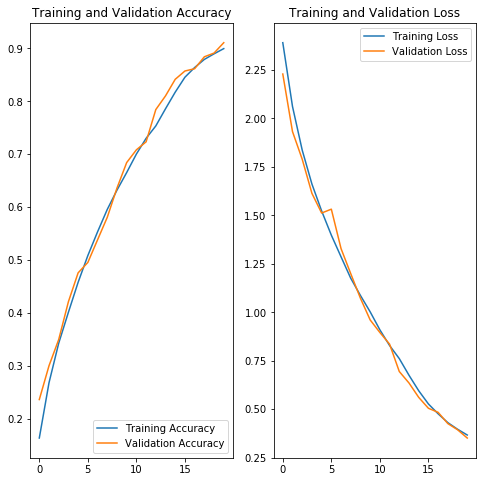

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Evaluation
* Test dataset을 이용해서 모델의 성능을 평가합니다.

In [28]:
checkpoint = tf.train.Checkpoint(model=model)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [29]:
model.load_weights(checkpoint_dir)

In [30]:
results = model.evaluate(test_dataset)

456/456 [==============================] - 29s 64ms/step - loss: 0.3442 - accuracy: 0.9078
